In [1]:
%pip install opencv-python > /dev/null
!apt update > /dev/null
!apt install ffmpeg libsm6 libxext6  -y > /dev/null

Note: you may need to restart the kernel to use updated packages.






In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, concatenate, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, RMSprop
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings
from tensorflow.keras.models import load_model
import itertools 
filterwarnings('ignore')
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2022-04-26 11:12:48.864778: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 11:12:48.942657: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 11:12:48.942840: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:

# from tensorflow.keras.mixed_precision import experimental as mixed_precision
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_policy(policy)
# print('Compute dtype: %s' % policy.compute_dtype)
# print('Variable dtype: %s' % policy.variable_dtype)


In [5]:
train_dir ="train"
val_dir = "val"
test_dir="test"
labels = ['benign', 'malignant']
label_np=np.array(labels)

In [6]:
import tensorflow as tf
import numpy as np
import os
import random


def set_seed(seed):
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)


seed = 101
set_seed(seed)

In [7]:
model1 = VGG16(include_top=False,input_shape=(224, 224,3), weights='imagenet')
input_shape = (224, 224)

2022-04-26 11:12:49.141288: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-26 11:12:49.142011: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 11:12:49.142221: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 11:12:49.142435: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning

58900480/58889256 [==============================] - 24s 0us/step


In [8]:
datagen_train = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  horizontal_flip=True,
                                  vertical_flip=False)



datagen_test = ImageDataGenerator(rescale=1./255)

datagen_val=ImageDataGenerator(rescale=1./255)

batch_size = 16
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,                                        
                                                    shuffle=True)

generator_val = datagen_val.flow_from_directory(directory=val_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)
generator_test=datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                 batch_size=batch_size,
                                                 shuffle=False)

Found 4065 images belonging to 2 classes.
Found 508 images belonging to 2 classes.
Found 508 images belonging to 2 classes.


In [9]:
def print_layer_trainable():
    for layer in model1.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))


# print_layer_trainable()

In [10]:
headModel = model1.output
headModel = layers.Flatten()(headModel)
#headModel = Dense(1024, activation="relu")(headModel)
headModel = Dense(512, activation="relu", dtype='float32')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="sigmoid")(headModel)
model = Model(inputs=model1.input, outputs=headModel)
# model.summary()

In [11]:
optimizer = Adam(lr=1e-5)
loss = 'categorical_crossentropy'
metrics = ['categorical_accuracy','accuracy','Precision','Recall']


model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

epochs = 100

steps_per_epoch = generator_train.n / batch_size
steps_test = generator_test.n / batch_size

#steps_per_epoch = 20
#steps_test = 50
early_stop = EarlyStopping(patience=3)
history = model.fit_generator(generator=generator_train,
                              epochs=epochs,
                              steps_per_epoch=steps_per_epoch,
                              validation_data=generator_val,
                              validation_steps=steps_test,
                              callbacks=[early_stop])


Epoch 1/100


2022-04-26 11:13:17.901777: I tensorflow/stream_executor/cuda/cuda_dnn.cc:379] Loaded cuDNN version 8303
2022-04-26 11:13:19.832697: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


254/254 [==============================] - 46s 157ms/step - loss: 0.5282 - categorical_accuracy: 0.7518 - accuracy: 0.7518 - precision: 0.6782 - recall: 0.8145 - val_loss: 0.5337 - val_categorical_accuracy: 0.7579 - val_accuracy: 0.7579 - val_precision: 0.7180 - val_recall: 0.8169
Epoch 2/100
254/254 [==============================] - 39s 154ms/step - loss: 0.4260 - categorical_accuracy: 0.8020 - accuracy: 0.8020 - precision: 0.7137 - recall: 0.8898 - val_loss: 0.3843 - val_categorical_accuracy: 0.8150 - val_accuracy: 0.8150 - val_precision: 0.7402 - val_recall: 0.9252
Epoch 3/100
254/254 [==============================] - 39s 151ms/step - loss: 0.3895 - categorical_accuracy: 0.8253 - accuracy: 0.8253 - precision: 0.7166 - recall: 0.9137 - val_loss: 0.3792 - val_categorical_accuracy: 0.8346 - val_accuracy: 0.8346 - val_precision: 0.7468 - val_recall: 0.9173
Epoch 4/100
254/254 [==============================] - 39s 153ms/step - loss: 0.3630 - categorical_accuracy: 0.8337 - accuracy: 0.

In [13]:
model.save("VGG16.h5")

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import keras_applications

from tensorflow.python.keras import backend
from tensorflow.python.keras import engine
from tensorflow.python.keras import layers
from tensorflow.python.keras import models
from tensorflow.python.keras import utils
from tensorflow.python.util import tf_inspect


def keras_modules_injection(base_fun):
  """Decorator injecting tf.keras replacements for Keras modules.
  Arguments:
      base_fun: Application function to decorate (e.g. `MobileNet`).
  Returns:
      Decorated function that injects keyword argument for the tf.keras
      modules required by the Applications.
  """

  def wrapper(*args, **kwargs):
    kwargs['backend'] = backend
    if 'layers' not in kwargs:
      kwargs['layers'] = layers
    kwargs['models'] = models
    kwargs['utils'] = utils
    return base_fun(*args, **kwargs)
  return wrapper



CLASS_INDEX = None
@keras_modules_injection
def test_my_decode_predictions(*args, **kwargs):
    return my_decode_predictions(*args, **kwargs)


def my_decode_predictions(preds, top=5, **kwargs):
    global CLASS_INDEX

    backend, _, _, keras_utils = get_submodules_from_kwargs(kwargs)

    # if len(preds.shape) != 2 or preds.shape[1] != 1000:
    #     raise ValueError('`decode_predictions` expects '
    #                      'a batch of predictions '
    #                      '(i.e. a 2D array of shape (samples, 1000)). '
    #                      'Found array with shape: ' + str(preds.shape))
    if CLASS_INDEX is None:
        fpath = keras_utils.get_file(
            'imagenet_class_index.json',
            CLASS_INDEX_PATH,
            cache_subdir='models',
            file_hash='c2c37ea517e94d9795004a39431a14cb')
        with open(fpath) as f:
            CLASS_INDEX = json.load(f)
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        result.sort(key=lambda x: x[2], reverse=True)
        results.append(result)
    return results


print('Predicted: ', test_my_decode_predictions(pred, top=10))

In [14]:
# img = Image.open("test/benign/24.jpg") 
# img = img.resize((224,224)) 
# img = np.array(img) 
# img = img / 255.0 
# img = img.reshape(1,224,224,3) 
# #base_model = inc_net.InceptionV3(weights='imagenet', include_top=False)
# preds = model.predict(img) 
# for x in decode_predictions(preds)[0]: 
#     print(x)


In [15]:
#Get the accuracy score

test_score = model.evaluate_generator(generator_test,20)



print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100)) 

print("[INFO] Loss: {:.2f}%".format(test_score[0] * 100)) 

[INFO] accuracy: 91.25%
[INFO] Loss: 22.15%


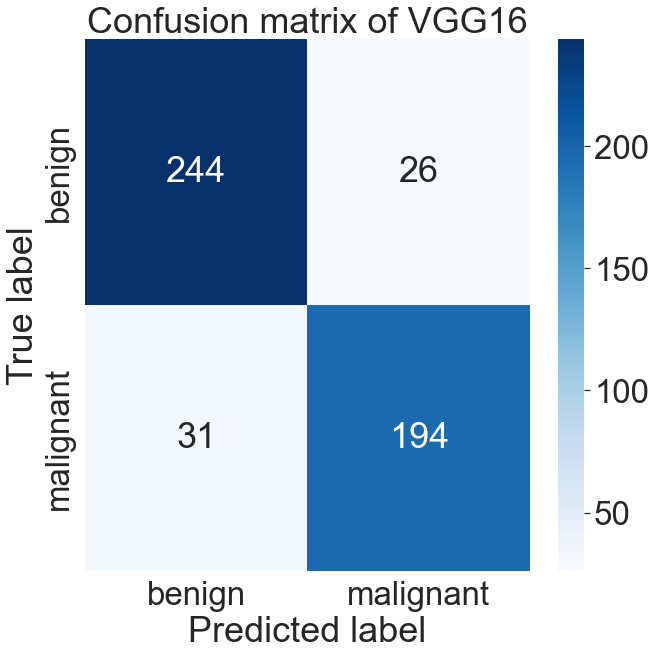

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
Y_pred = model.predict_generator(generator_val)
y_pred = np.argmax(Y_pred, axis=1)
array = confusion_matrix(generator_val.classes, y_pred)
df_cm = pd.DataFrame(array, index =['benign', 'malignant'],
                  columns = ['benign', 'malignant'])
plt.figure(figsize=(10,10))
sn.set(font_scale=2)
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix of VGG16')
plt.tight_layout()
plt.savefig('VGG16_confusion',dpi=200); 
plt.show()

In [ ]:
# def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix of VGG16', cmap=plt.cm.Blues):


#     plt.figure(figsize=(8,8))

#     plt.imshow(cm, interpolation='nearest', cmap=cmap)

#     plt.title(title)

#     plt.colorbar()



#     tick_marks = np.arange(len(classes))

#     plt.xticks(tick_marks, classes, rotation=45)

#     plt.yticks(tick_marks, classes)



#     if normalize:

#         #cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

#         #cm = np.around(cm, decimals=2)

#         #cm[np.isnan(cm)] = 0.0

#         print("Normalized confusion matrix")

#     else:

#         print('Confusion matrix, without normalization')

#     thresh = cm.max() / 2.

#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

#         plt.text(j, i, cm[i, j],

#                  horizontalalignment="center",

#                  color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()

#     plt.ylabel('True label')

#     plt.xlabel('Predicted label')

In [ ]:
target_names = []

for key in generator_train.class_indices:

    target_names.append(key)



print(target_names)

In [ ]:
# Y_pred = model.predict_generator(generator_test)

# y_pred = np.argmax(Y_pred, axis=1)

# print('Confusion Matrix')

# cm = confusion_matrix(generator_test.classes, y_pred)

# plot_confusion_matrix(cm, target_names, title='Confusion matrix of VGG16')
# print(cm)

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(30, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall','accuracy',  'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
preds = model.predict_generator(generator_test)
print(preds)

In [ ]:
print(classification_report(generator_test.classes, y_pred))

In [ ]:
Tp=124
Tn=255
Fp=1
Fn=2

sensitivity=Tp/(Tp+Fn)
specificity=Tn/(Tn+Fp)
print("[INFO] Sensitivity: {:.2f}%".format(sensitivity * 100)) 
print("[INFO] Specificity: {:.2f}%".format(specificity * 100)) 

In [ ]:
predicted_class_indices=np.argmax(preds,axis=1)
a=0
b=0
for x in predicted_class_indices:
    if x==0:
        a+=1
    else:
        b+=1
print(a," ",b)

In [ ]:
predicted_class_indices

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].grid(color = '#e0e0eb')
    ax[i].legend(['train', 'val'])

In [ ]:

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()
for i, met in enumerate([ 'categorical_accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('VGG16 Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].grid(color = '#e0e0eb')
    ax[i].legend(['train', 'val'],loc='best')
plt.show()

In [ ]:

plt.figure(figsize=(8, 5))
ax = plt.axes()
ax.set_facecolor("#eaeaf2")
plt.plot(history.history['accuracy'],label="train accuracy")
plt.plot(history.history['val_accuracy'],label="val accuracy")
plt.title('VGG16 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid(color = 'w')
plt.savefig('VGG16_accuracy',dpi=200); 
plt.show()


In [ ]:
plt.figure(figsize=(8, 5))

ax = plt.axes()
ax.set_facecolor("#eaeaf2")
plt.plot(history.history['loss'],label="train loss")
plt.plot(history.history['val_loss'],label="val loss")
plt.title('VGG16 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.grid(color = 'w')
plt.savefig('VGG16_loss',dpi=200); 
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score,roc_curve
r_probs = [0 for _ in range(len(generator_test.classes))]
r_auc = roc_auc_score(generator_test.classes, r_probs)
r_rfpr, r_trpr, rthresh = roc_curve(generator_test.classes, r_probs)
fpr = {}
tpr = {}
thresh ={}

n_class = 2

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(generator_test.classes, Y_pred[:,i], pos_label=i)
    #print(fpr[i],' -----' ,tpr[i],'-------', thresh[i])
    
# plotting    
#plt.plot(fpr[0], tpr[0], linestyle='--',color='red', label='Normal')
plt.plot(fpr[1], tpr[1], linestyle='solid',color='green', label='Tumor')
plt.plot(r_rfpr, r_trpr, linestyle='--',color='blue', label='Random Thereshold')
plt.title(' ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('VGG16_ROC',dpi=200); 

In [ ]:
print(fpr[0])

In [ ]:
print(fpr[1])

In [ ]:
print(tpr[0])

In [ ]:
print(tpr[1])

In [ ]:
print(r_rfpr)

In [ ]:
print(r_trpr)

In [ ]:
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os


def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(128, 256))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.hsplit(img_tensor,2)[1]
    img_tensor=np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor


if __name__ == "__main__":

    # load model
    model = load_model("VGG16.h5")

    # image path
    #img_path = "E:/Final_Dataset_Thesis/full image/normal/Normal- (4981).jpg"   # normal
    img_path = "E:/Final_Dataset_Thesis/full image/Test/tumor/Tumor- (1411).jpg"     # tumor

    # load a single image
    new_image = load_image(img_path)

    # check prediction
    pred = model.predict(new_image)
    print(pred)
    m=np.argmax(pred,axis=1)
    print('Predicted:', m)